# Обработка документов: очистка, токенизация, лемматизация. Создание корпуса документов



Тексты статей представлены в формате *tex*. C помощью [регулярных выражений](https://docs.python.org/3/howto/regex.html) очистим документы (удаляем текст, заключенный в фигурные скобки; *latex*-команды и др.), оставляя непосредственно текст статьи. Выделенный текст разобьем на токены (слова) и приведем к нижнему регистру. Далее для полученных токенов можно выполнить лемматизацию (приведение к начальной форме).  

В корпус будем записывать информацию о статье (идентификатор, название, главная категория, категории, и ссылки на скачивание статьи) и непосредственно текст статьи в виде строки.


## Загрузка данных

In [1]:
import os
import re
import csv
import time
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

pd.set_option('display.max_columns', None)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

from matplotlib import rc
font = {'family': 'Verdana', 'weight': 'normal'}
rc('font', **font)

import warnings
warnings.filterwarnings('ignore')

Укажем путь к tex-файлам и документу с [метаинформацией](https://drive.google.com/open?id=0B_NefGKQ1pCsZEJ5VkhueFZXVEk)

In [2]:
path_tex = 'C:/Users/user/Downloads/arxiv/source/valid/'
path_meta = 'D:/_data_science/@@projects/2017_diploma-nlp/data/'

In [3]:
queries = pd.read_csv(path_meta + "unique_queries.csv", encoding='cp1251', index_col='id')
print(queries.shape)
queries.head()

(873346, 5)


,title,primary_category,category,source_link,pdf_link
id,,,,,
0710.3447v1,Problems of Testology,stat.AP,['stat.AP'],http://arxiv.org/e-print/0710.3447v1,http://arxiv.org/pdf/0710.3447v1
0907.2480v1,Thoughts on new statistical procedures for age...,stat.AP,"['stat.AP', 'stat.ME']",http://arxiv.org/e-print/0907.2480v1,http://arxiv.org/pdf/0907.2480v1
1108.0301v1,On the Concept of Snowball Sampling,stat.AP,['stat.AP'],http://arxiv.org/e-print/1108.0301v1,http://arxiv.org/pdf/1108.0301v1
1203.1421v1,A note on characterization based on past entropy,stat.AP,['stat.AP'],http://arxiv.org/e-print/1203.1421v1,http://arxiv.org/pdf/1203.1421v1
1012.4702v1,Experience Rating with Poisson Mixtures,stat.AP,['stat.AP'],http://arxiv.org/e-print/1012.4702v1,http://arxiv.org/pdf/1012.4702v1


## Обзор датасета

Пример записи

In [4]:
queries.loc['1210.3718v1']

title               On the Role of Contrast and Regularity in Perc...
primary_category                                                cs.CV
category                                         ['cs.CV', 'stat.AP']
source_link                      http://arxiv.org/e-print/1210.3718v1
pdf_link                             http://arxiv.org/pdf/1210.3718v1
Name: 1210.3718v1, dtype: object

In [5]:
tex_files = []
for root, directory, files in os.walk(path_tex):
    tex_files += files

In [6]:
print("Количество статей: %d" % len(tex_files))

Количество статей: 195518


In [7]:
names = [file[:-4] for file in tex_files]
dataset_queries = queries.loc[names]

Посмотрим как распределяются категории. Построим гистограмму распределения частот всех категорий.

### Главные категории

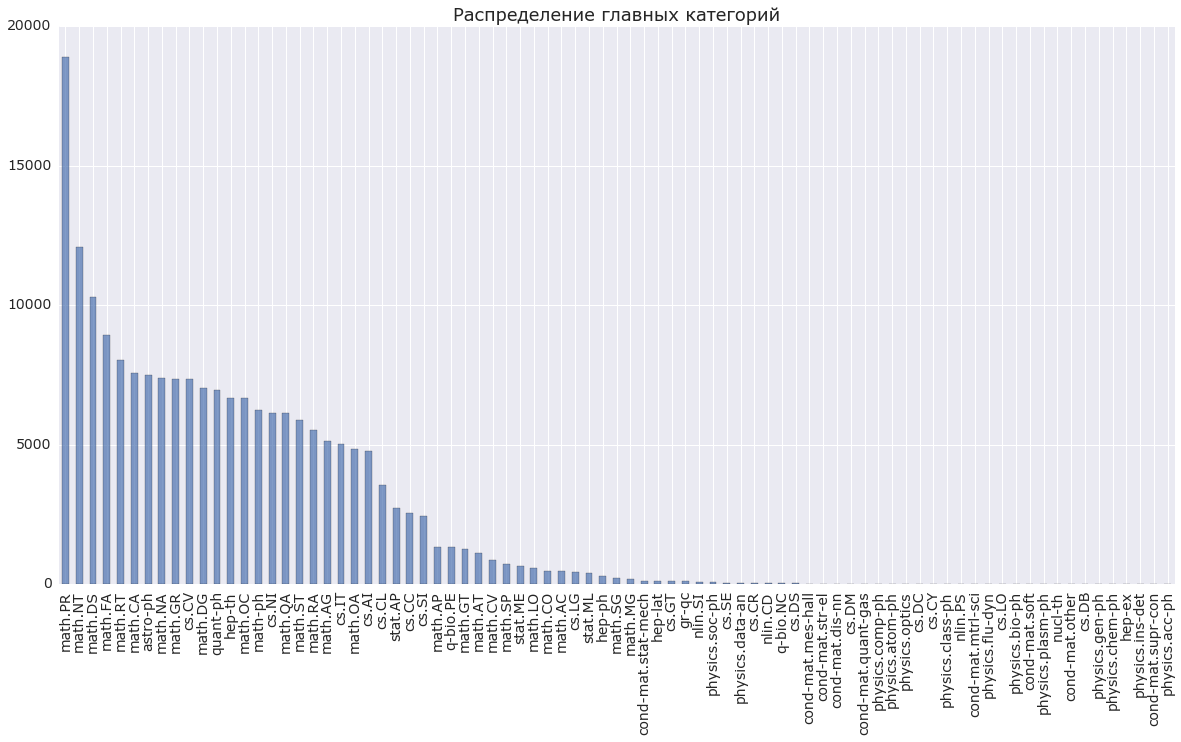

Количество категорий: 81
Среднее количество статей в категории: 2407
Медиана: 205


In [8]:
plt.figure(figsize=(20,10))
category_counts = dataset_queries.primary_category.value_counts()
category_counts.plot(kind='bar', alpha=0.7)
plt.title("Распределение главных категорий", fontsize=18)
plt.show()
print('Количество категорий: %d' % dataset_queries.primary_category.nunique())
print('Среднее количество статей в категории: %d' % int(np.mean(category_counts)))
print('Медиана: %d' % int(np.median(category_counts)))

Количество статей в категориях

In [9]:
category_counts[:30]

math.PR     18911
math.NT     12078
math.DS     10304
math.FA      8925
math.RT      8020
math.CA      7560
astro-ph     7511
math.NA      7390
math.GR      7362
cs.CV        7353
math.DG      7029
quant-ph     6950
hep-th       6672
math.OC      6660
math-ph      6240
cs.NI        6135
math.QA      6120
math.ST      5892
math.RA      5519
math.AG      5129
cs.IT        5020
math.OA      4836
cs.AI        4775
cs.CL        3567
stat.AP      2721
cs.CC        2545
cs.SI        2435
math.AP      1329
q-bio.PE     1323
math.GT      1243
Name: primary_category, dtype: int64

### Все категории

In [10]:
cat_lists = dataset_queries.category
cat_list = []

In [11]:
for cat in cat_lists:
    try:
        cat_list += eval(cat)
    except Exception:
        continue

In [12]:
cat_df = pd.DataFrame(cat_list, columns=['categories'])

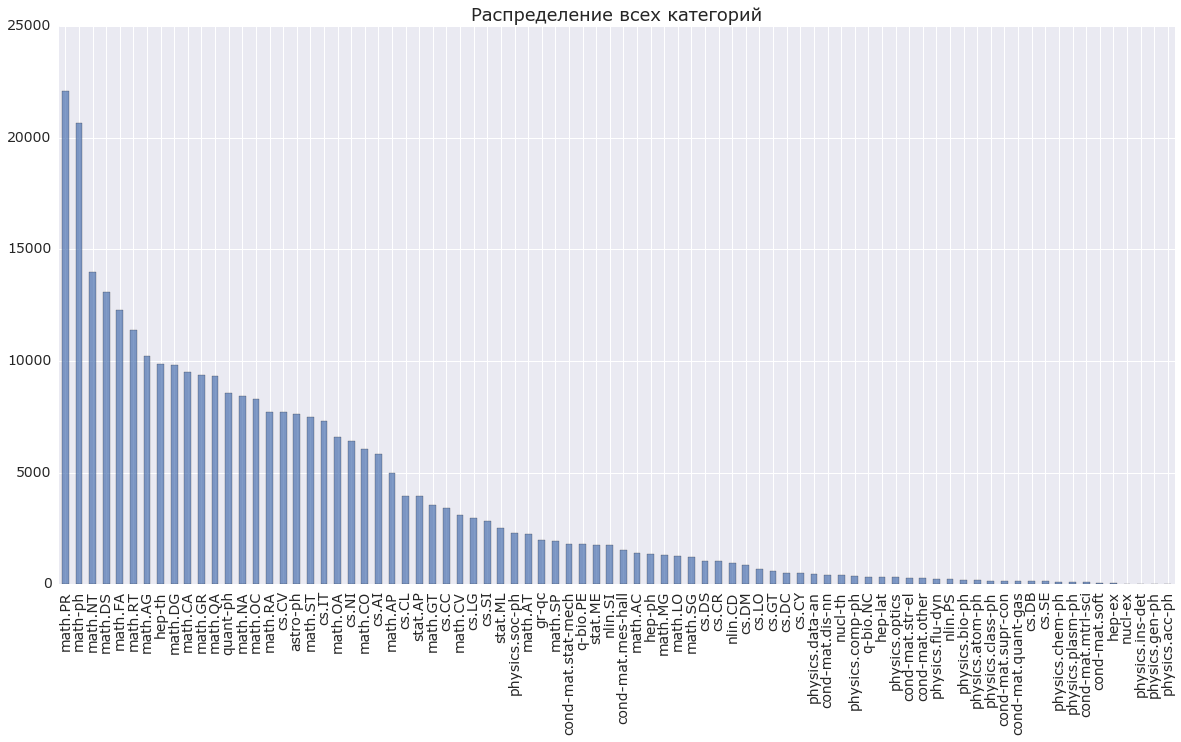

Количество категорий: 82
Среднее количество статей в категории: 3730
Медиана: 1629


In [13]:
plt.figure(figsize=(20,10))
category_counts = cat_df.categories.value_counts()
category_counts.plot(kind='bar', alpha=0.7)
plt.title("Распределение всех категорий", fontsize=18)
plt.show()
print('Количество категорий: %d' % cat_df.categories.nunique())
print('Среднее количество статей в категории: %d' % int(np.mean(category_counts)))
print('Медиана: %d' % int(np.median(category_counts)))

Посмотрим к какому количеству тем относятся документы.

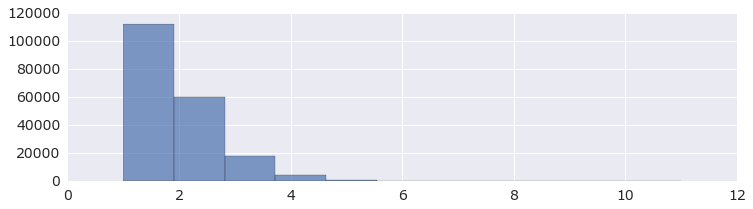

Максимальное число тем: 11
Минимальное число тем: 1
Среднее число тем: 1.569


In [14]:
freq = []
for i in list(dataset_queries.category):
    try:
        freq.append(len(eval(i)))
    except Exception:
        continue

plt.figure(figsize=(12,3))
plt.hist(freq, alpha=0.7, bins=11)
plt.show()

print("Максимальное число тем: %d" % max(freq))
print("Минимальное число тем: %d" % min(freq))
print("Среднее число тем: %.3f" % np.mean(freq))

## Обработка статей

In [15]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
stopwords = set(stopwords.words('english'))

In [16]:
'''
Подход с определением частей речи работает хуже, чем наивный.

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatization_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    tagged = nltk.pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word,tag in tagged]
    return lemmatized    
'''

def lemmatization_word(word):
    pos = ['a','v','n','r']
    lemmatizer = WordNetLemmatizer()
    for p in pos:
        temp = lemmatizer.lemmatize(word, p)
        if temp != word:
            return temp
    return word  


def clean_article(path_tex, file, punc=False, lemmatization=False, stopword=False):
    '''
    Description
    try:
        raw_text = open(path_tex + file).read()
    except Exception:
        #raw_text = open(path_tex + file, encoding='ISO-8859-1').read()
        raw_text = open(path_tex + file, encoding='cp1251').read()
    '''
    raw_text = open(path_tex + file, encoding='cp1251').read()
    
    junk = re.compile(r'({.*})|([\{\}\%\\\^=\&\'].*\W)|(\~)')              # выбросить выражения в скобках и команды
    text = junk.sub(" ", raw_text)
    sep = re.compile(r'\s+')                                               # разбить по пробельному символу
    tokens = sep.split(text)
    
    # Отбрасывание русских статей
    piece = bytes(''.join(tokens[:10]), encoding='cp1251')
    soap = BeautifulSoup(piece)
    if soap.original_encoding == 'windows-1252':                           # определяем оригинальную кодировку
        return None
    
    # приведение к нижнему регистру и удаление формул
    tokens = [token.lower() for token in tokens if '$' not in token and '_' not in token]
    
    # токенизация с учетом пунктуации
    tokens = wordpunct_tokenize(' '.join(tokens))
    
    # удаление знаков пунктуации и прочих спецсимволов
    if punc:
        tokens = [token for token in tokens if token.isalpha()]
        
    # удаление стоп-слов
    if stopword:
        tokens = [token for token in tokens if token not in stopwords]
    
    # лемматизация токенов
    if lemmatization:
        tokens = [lemmatization_word(token) for token in tokens]

    symbols = [token for token in tokens if token.isalpha() and len(token) < 2]
    tokens = [token for token in tokens if token not in symbols]
    
    return ' '.join(tokens)

In [17]:
%%time 
print(clean_article(path_tex, '0001075v1.tex')[:1000])

94720 model of unsteady filtration ( seepage ) in porous medium with capillary retention is considered . it leads to free boundary problem for generalized porous medium equation where the location of the boundary of the water mound is determined as part of the solution . the numerical solution of the free boundary problem is shown to possess self - similar intermediate asymptotics . on the other hand , the asymptotic solution can be obtained from non - linear boundary value problem . numerical solution of the resulting eigenvalue problem agrees with the solution of the partial differential equation for intermediate times . in the second part of the work , we consider the problem of control of the water mound extension by forced drainage . in the present work two problems from the theory of filtration through horizontal porous stratum are considered . first we study short , but intense , flooding followed by natural outflow through the vertical face of an aquifer . further , we consider

Пример обработки теста

In [18]:
%%time 
print(clean_article(path_tex, '0001075v1.tex', punc=True, lemmatization=True, stopword=True)[:1000])

model unsteady filtration seepage porous medium capillary retention consider lead free boundary problem generalize porous medium equation location boundary water mound determine part solution numerical solution free boundary problem show posse self similar intermediate asymptotics hand asymptotic solution obtain non linear boundary value problem numerical solution result eigenvalue problem agree solution partial differential equation intermediate time second part work consider problem control water mound extension force drainage present work two problem theory filtration horizontal porous stratum consider first study short intense flood follow natural outflow vertical face aquifer consider possibility control spread water mound use force drainage boundary important practical example problem groundwater mound formation extension follow flood breakthrough dam water possibly contaminate enter slowly extend river bank consider aquifer consist long porous stratum impermeable bed bottom perm

## Создание корпуса

In [19]:
def make_corpora(path_tex, queries=queries, actual_category=None, corpora='corpora.csv', append=False, \
                  punc=False, lemma=False, stop=False):
    '''
    Description
    '''
    if append:
        f = open(corpora, 'a') # дописать в уже созданный файл
    else:
        f = open(corpora, 'w+') # создание файла для записи
        
    names = ['arxiv_id','title','primary_category','categories','text']
    writer = csv.DictWriter(f, fieldnames=names)
    writer.writeheader()
    
    files = os.listdir(path_tex)
    article_names = [f[:-4] for f in files]

    tex_files = filter(lambda file: file.endswith('.tex'), files) # выбираем файлы с расширением tex
    
    for file in tex_files:
        name = file[:-4]
        try:
            text = clean_article(path_tex, file, punc=punc, lemmatization=lemma, stopword=stop)
            if len(text) > 500:
                title = queries.get_value(name, 'title')
                primary_cat = queries.get_value(name, 'primary_category')
                categories = eval(queries.get_value(name, 'category'))
                if primary_cat not in categories:
                    categories += [primary_cat]

                writer.writerow({'arxiv_id': name, 'title': title, 'primary_category': primary_cat, \
                             'categories': categories, 'text': text})
        except Exception:
                continue
    f.close()

## Сохранение корпуса на диск

In [7]:
path = 'C:/Users/user/Downloads/arxiv/source/valid/math.PR/'
test_files = os.listdir(path)
print(len(test_files))

18908


In [9]:
%%time

make_corpora(path, corpora='corpora_lem.csv', append=True, lemma=True, punc=True, stop=False) # со стоп-словами

Wall time: 1h 26min 15s
